In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mat73
import pickle

from MARBLE import utils, plotting

from sklearn.decomposition import PCA
import jPCA

import neo
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel
from quantities import ms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load data compiled into matlab cell array
spiking_data = mat73.loadmat('../../outputs/spiking_data/conditions_spiking_data.mat')['all_results']

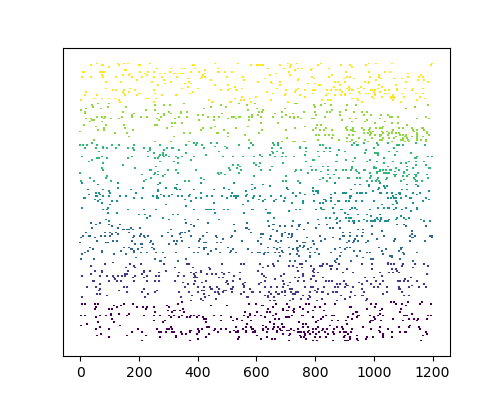

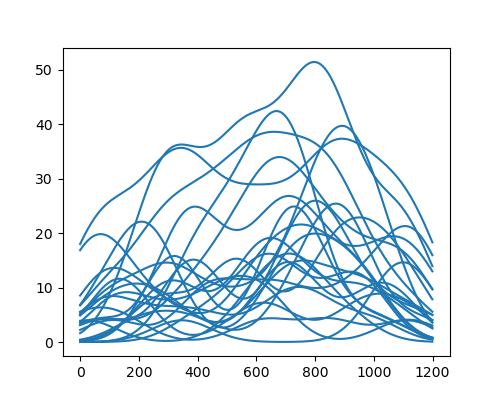

In [35]:
trial = 1
session = 9

spikes, colors = [], []
for cond in range(7):
    st = spiking_data[session][cond][trial][0][:,:]
    spikes += [np.where(st[ch,:])[0] for ch in range(24)]
    colors += [cm.viridis(cond/6) for _ in range(24)]

_, ax = plt.subplots(figsize=(5,4))
ax.eventplot(spikes, color=colors)
ax.get_yaxis().set_ticks([])
plt.savefig('../outputs/spikes.svg')
plt.show()

_, ax = plt.subplots(figsize=(5,4))
gk = GaussianKernel(100*ms) # increase this for smoother signals (previously used auto)

for sp in spikes[:24]:
    st = neo.SpikeTrain(sp, units='ms', t_stop=1200)
                        
    # ek = ExponentialKernel(100*ms) # assymetric kernel and not smooth output
    inst_rate = instantaneous_rate(st, kernel=gk, sampling_period=1*ms).magnitude
    ax.plot(inst_rate, 'C0')
    
plt.show()

In [36]:
pos, vel, time, _ = pickle.load(open('../../outputs/spiking_data/raw_data_session_{}_3D.pkl'.format(session),'rb'))

1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
1 [(0, 0, 0), (0.267968, 0.223549, 0.512008, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.472873, 1.0)]
4 [(0, 0, 0), (0.20803, 0.718701, 0.4728

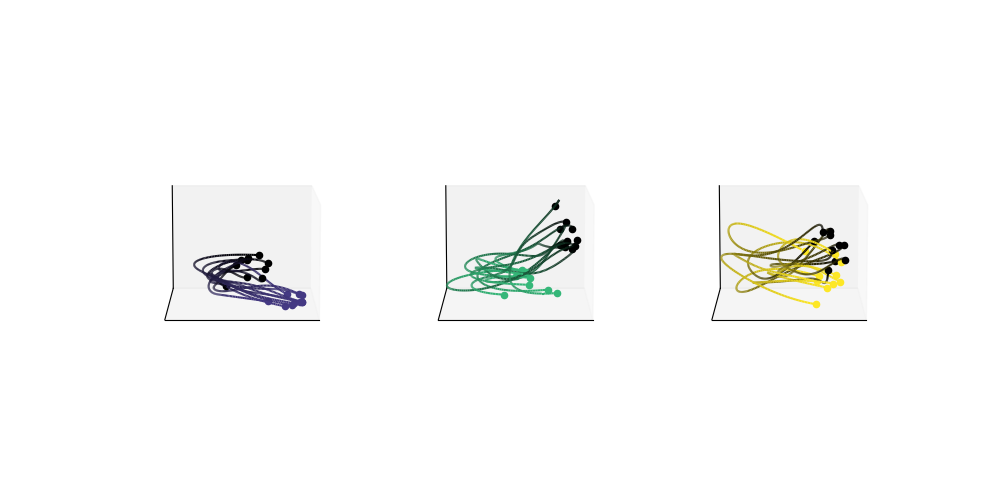

In [46]:
fig = plt.figure(figsize=(10,5))
n_traj=10
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.art3d import Line3DCollection

for i,cond in enumerate([1,4,6]):
    ax = fig.add_subplot(int('13{}'.format(i+1)), projection='3d')
    ax.view_init(elev=10., azim=90)
    starts = np.where(time[cond]==0)[0]
    for j in range(n_traj):
        t = range(starts[j], starts[j+1]-1)
        p = pos[cond][t]
        segments = np.stack([p[:-1], p[1:]], axis=1)
        
        colors = [(0, 0, 0), cm.viridis(cond/6)] # first color is black, last is red
        cmap = LinearSegmentedColormap.from_list("Custom", colors, N=len(time[cond][t]))
        r = cmap(np.linspace(0,1,len(time[cond][t])))
        
        ax.add_collection(Line3DCollection(segments,colors=list(r)))
        ax.set_xlim([min(pos[cond][:,0]), max(pos[cond][:,0])])
        ax.set_ylim([min(pos[cond][:,1]), max(pos[cond][:,1])])
        ax.set_zlim([min(pos[cond][:,2]), max(pos[cond][:,2])])
        
        ax.scatter(pos[cond][starts[j],0],pos[cond][starts[j],1],pos[cond][starts[j],2],color=colors[0])
        ax.scatter(pos[cond][starts[j+1]-1,0],pos[cond][starts[j+1]-1,1],pos[cond][starts[j+1]-1,2],color=colors[1])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_zaxis().set_ticks([])

plt.savefig('../outputs/trajectories.svg')

In [48]:
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=10, stop_crit=0.05, vector=False)

---- Embedding dimension: 3
---- Signal dimension: 3

Vector computations are disabled

---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


/tmp/ipykernel_726306/1981000640.py:10: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../outputs/trajectories_{}.svg'.format(i))


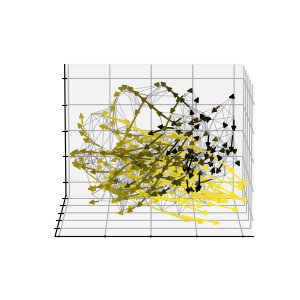

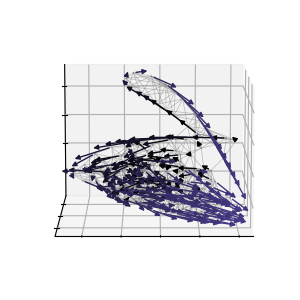

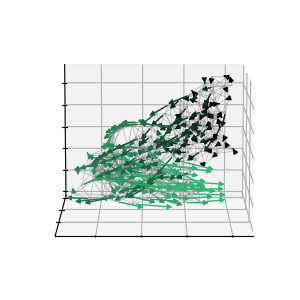

In [54]:
data_plot = data.to_data_list()
for i in [1,4,6]:
    d = data_plot[i]
    c = [(0, 0, 0), cm.viridis(i/6)] # first color is black, last is Ci
    cmap = LinearSegmentedColormap.from_list("Custom", c, N=140)
    ind = np.linspace(0,1,140)
    colors = cmap(ind[time[i][d.sample_ind].astype(int)])
    plotting.fields([d], view=(10,90), figsize=(3,3), scale=2, width=7., color=colors, axes_visible=False)
    plt.axis('on')
    plt.savefig('../outputs/trajectories_{}.svg'.format(i))
        
plt.show()